In [137]:
import torch
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import numpy as np

In [138]:
transform = transforms.Compose([transforms.Resize((264)),
                                       transforms.RandomCrop(264),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Load the image data set 
dataset = datasets.ImageFolder('/content/drive/MyDrive/caltech101_classification', transform=transform)
batch_size = 3
#The data is divided into training data which is of 70% and testing data of 30%
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state= 45)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size= 3, shuffle= True, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size= 3, shuffle= False, num_workers = 2)
classes = ('Motorbikes','airplanes','schooner')
print ('The observed labels in dataset are:', classes)

The observed labels in dataset are: ('Motorbikes', 'airplanes', 'schooner')


In [139]:
import matplotlib.pyplot as plt
import numpy as np

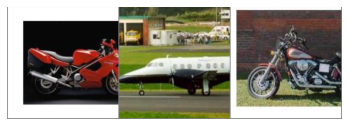

Motorbikes airplanes Motorbikes


In [148]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

In [140]:
print(f" '{len(train_data)+len(test_data)}' images were found in the given kaggle dataset") 
print(f" '{str(len(train_data))}' are for training the dataset") 
print(f" '{str(len(test_data))}' are for testing the dataset")
print("\n Shape of the image:" ,images.shape)
#where 10 - number of images in a single batch ,3 - number of channels, 224 - width & height of the image

 '1661' images were found in the given kaggle dataset
 '1162' are for training the dataset
 '499' are for testing the dataset

 Shape of the image: torch.Size([1, 3, 264, 264])


In [141]:
import torch.nn as nn
import torch.nn.functional as F

In [142]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(63504 , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [143]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
Model_Name = "M1"
optimizer = optim.Adagrad(net.parameters(), lr=0.05) 

In [144]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [145]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
# move tensors to GPU if CUDA is available
if train_on_gpu:
    net.cuda()

CUDA is not available.  Training on CPU ...


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [146]:
from tqdm import tqdm
import time

In [147]:
start_time = int(time.time())
epoch = 1
for epoch in range(epoch):  
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
end_time = int(time.time())
print('\n Finished Training')
fl1_time = end_time-start_time

200it [00:31,  4.82it/s]

[1,   200] loss: 1.730


388it [01:01,  6.27it/s]


 Finished Training


In [149]:
import pandas as pd

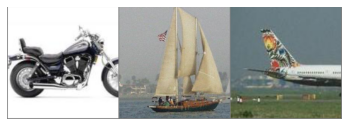

GroundTruth:  Motorbikes schooner airplanes


,0,1,2
Ground Truth,0,2,1
Predicted label,0,1,1


In [150]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
n_test = 10
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))
df_result = pd.DataFrame({
    'Ground Truth': labels[:n_test],
    'Predicted label': predicted[:n_test]})
display(df_result.T)

In [151]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(3)))

Predicted:  Motorbikes airplanes airplanes


In [152]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        M1 = {100 * correct // total}

print('Accuracy of the network on the test data images in percentage = ' + str(M1))

Accuracy of the network on the test data images in percentage = {53}


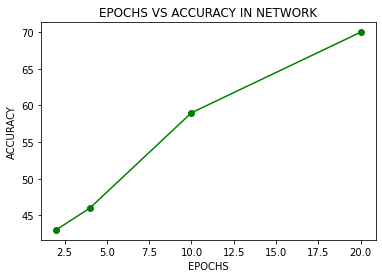

In [153]:
#obeservation
epochs = [2, 4, 10, 20]
Accuracy = [43 , 46, 59, 70]
#Plot a line chart
plt.plot(epochs , Accuracy, 'o-g')
#set axis titles
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
#set chart title
plt.title("EPOCHS VS ACCURACY IN NETWORK")
plt.show()


In [154]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.conv3 = nn.Conv2d(12,18, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(15138, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120,84)
        self.fc4 = nn.Linear(84, 32)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x
net1 = Net1()

In [155]:
criterion = nn.CrossEntropyLoss()
Model_Name = "M2"
optimizer = optim.Adam(net1.parameters(), lr=0.005)

In [156]:
start_time = int(time.time())
epoch = 15
for epoch in range(epoch):  
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
end_time = int(time.time())
print('Finished Training')

201it [00:36,  5.62it/s]

[1,   200] loss: 0.127


388it [01:10,  5.48it/s]
201it [00:36,  6.35it/s]

[2,   200] loss: 1.899


388it [01:09,  5.55it/s]
201it [00:36,  6.24it/s]

[3,   200] loss: 0.080


388it [01:09,  5.59it/s]
201it [00:37,  6.18it/s]

[4,   200] loss: 1.029


388it [01:12,  5.34it/s]
201it [00:35,  6.31it/s]

[5,   200] loss: 0.073


388it [01:13,  5.28it/s]
200it [00:37,  4.06it/s]

[6,   200] loss: 0.060


388it [01:12,  5.37it/s]
201it [00:36,  5.42it/s]

[7,   200] loss: 0.285


388it [01:12,  5.35it/s]
201it [00:43,  5.35it/s]

[8,   200] loss: 68.319


388it [01:28,  4.36it/s]
200it [00:53,  2.83it/s]

[9,   200] loss: 3.493


388it [01:42,  3.80it/s]
201it [00:59,  3.95it/s]

[10,   200] loss: 2.062


388it [01:53,  3.42it/s]
200it [00:52,  5.62it/s]

[11,   200] loss: 1.548


388it [01:50,  3.52it/s]
201it [00:59,  5.16it/s]

[12,   200] loss: 0.901


388it [01:50,  3.52it/s]
201it [00:54,  5.29it/s]

[13,   200] loss: 0.919


388it [01:43,  3.75it/s]
201it [01:01,  4.00it/s]

[14,   200] loss: 0.843


388it [01:50,  3.52it/s]
201it [00:49,  5.42it/s]

[15,   200] loss: 0.883


388it [01:39,  3.91it/s]

Finished Training


In [157]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [158]:
import time
from tqdm import tqdm

In [161]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net1(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        M2 = {100 * correct // total}

print('Accuracy of the network on the test data images in percentage = ' + str(M2))

Accuracy of the network on the test data images in percentage = {76}


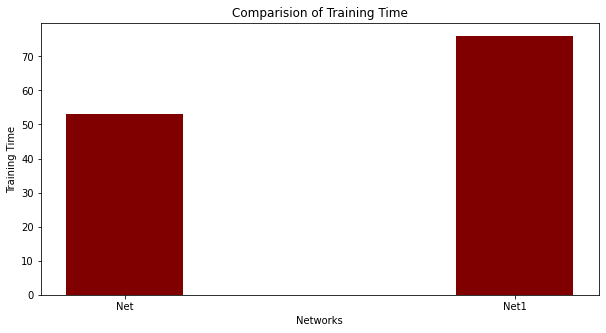

In [187]:
ds = {'Net':M1,'Net1':M2}
courses = list(ds.keys())
values = list(ds.values())
lis=[]
for i in values:
  lis.append(list(i))
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, lis , color ='maroon',
        width = 0.3)
plt.title("Comparision of Training Time") 
plt.xlabel("Networks")
plt.ylabel("Training Time")
plt.show()